In [7]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [8]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [9]:
from random import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

data = pd.read_csv("/content/cleaned_last.csv")
X = data.drop(columns=['IS_FRAUD']).values
y = data['IS_FRAUD'].values

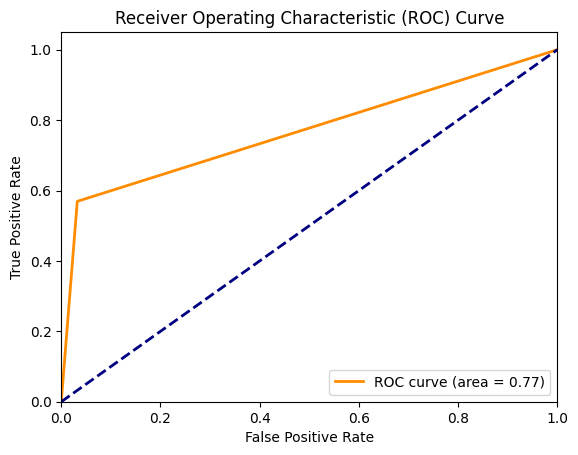

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest(n_trees=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.9215686274509803


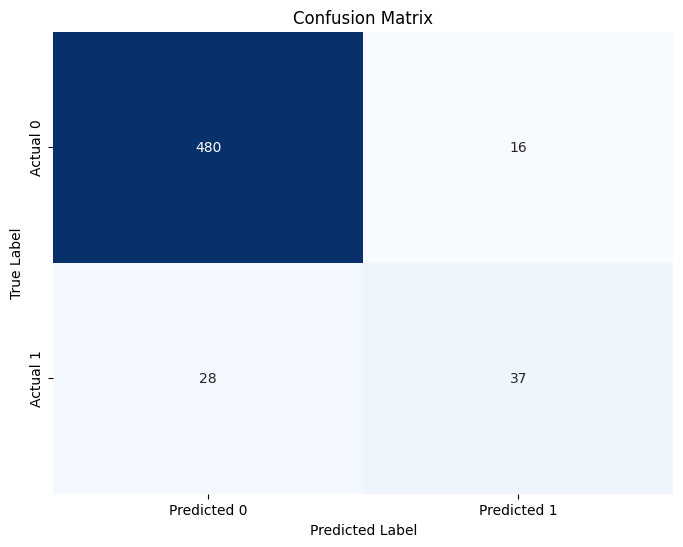

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/cleaned_last.csv")
X = data.drop(columns=['IS_FRAUD']).values
y = data['IS_FRAUD'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

clf = RandomForest(n_trees=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Split into majority and minority
majority = data[data['IS_FRAUD'] == 0]
minority = data[data['IS_FRAUD'] == 1]

print("Majority class:", len(majority))
print("Minority class:", len(minority))


Majority class: 2428
Minority class: 376


In [15]:
n_majority = len(majority)
n_minority = len(minority)
minority_oversampled = minority.sample(n=n_majority, replace=True, random_state=42)
df_oversampled = pd.concat([majority, minority_oversampled])
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_oversampled['IS_FRAUD'].value_counts())

IS_FRAUD
0    2428
1    2428
Name: count, dtype: int64


In [16]:
sk = df_oversampled

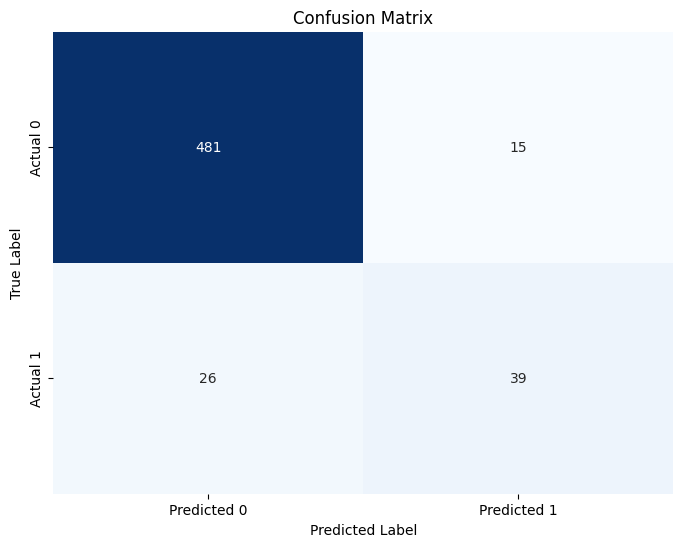

In [18]:

X1 = sk.drop(columns=['IS_FRAUD']).values
y1 = sk['IS_FRAUD'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=1234
)

clf = RandomForest(n_trees=100)
clf.fit(X1_train, y1_train)
predictions = clf.predict(X1_test)

cm = confusion_matrix(y1_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()